In [1]:
import gzip
import json
import math
import numpy
import random
import sklearn
import string
from collections import defaultdict
import numpy as np
import pandas as pd

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
reviews = []
f1 = open("D:/FA24/CSE258/ASS2/renttherunway_final_data.json")
for l1 in f1:
    try:
        d = eval(l1)
    except:
        l1 = l1.replace('null', "'None'")
        d = eval(l1)
    reviews.append(d)
f1.close()

In [4]:
runway = pd.DataFrame(reviews)[['fit', 'user_id', 'item_id', 'weight', 'height', 'size']]

In [5]:
runway_clean = runway.dropna()
X = runway_clean[['weight', 'height']]
y = runway_clean['fit']

In [6]:
runway['weight'] = runway['weight'].str.replace('lbs','')

In [7]:
data1 = runway.replace({'fit': 1, 'small': 0, 'large': 0})
data2 = runway.replace({'fit': 0, 'small': 1, 'large': 0})
data3 = runway.replace({'fit': 0, 'small': 0, 'large': 1})
data1 = data1[['user_id', 'item_id', 'fit']]
data2 = data2[['user_id', 'item_id', 'fit']]
data3 = data3[['user_id', 'item_id', 'fit']]

In [8]:
import random
random.seed(1)
shuffled_df = data1.sample(frac = 1, random_state=42)

train1, validate1 = np.split(shuffled_df,
                       [int(.8*len(shuffled_df))])
random.seed(1)
shuffled_df2 = data2.sample(frac = 1, random_state=42)

train2, validate2 = np.split(shuffled_df2,
                       [int(.8*len(shuffled_df))])
random.seed(1)
shuffled_df3 = data3.sample(frac = 1, random_state=42)

train3, validate3 = np.split(shuffled_df3,
                       [int(.8*len(shuffled_df))])

In [9]:
fitTrain = train1[['user_id', 'item_id', 'fit']].to_numpy()
fitValid = validate1[['user_id', 'item_id', 'fit']].to_numpy()
fitTrain2 = train2[['user_id', 'item_id', 'fit']].to_numpy()
fitValid2 = validate2[['user_id', 'item_id', 'fit']].to_numpy()
fitTrain3 = train3[['user_id', 'item_id', 'fit']].to_numpy()
fitValid3 = validate3[['user_id', 'item_id', 'fit']].to_numpy()

In [10]:
temp = train1.set_index('user_id')[['item_id', 'fit']]
temp['tup'] = temp.apply(lambda row: (row['item_id'],row['fit']),axis=1)
fitPerUser = temp.reset_index().groupby('user_id')['tup'].agg(list).to_dict()

temp2 = train1.set_index('item_id')[['user_id', 'fit']]
temp2['tup'] = temp2.apply(lambda row: (row['user_id'],row['fit']),axis=1)
fitPerItem = temp2.reset_index().groupby('item_id')['tup'].agg(list).to_dict()

In [11]:
temp = train2.set_index('user_id')[['item_id', 'fit']]
temp['tup'] = temp.apply(lambda row: (row['item_id'],row['fit']),axis=1)
fitPerUser2 = temp.reset_index().groupby('user_id')['tup'].agg(list).to_dict()

temp2 = train2.set_index('item_id')[['user_id', 'fit']]
temp2['tup'] = temp2.apply(lambda row: (row['user_id'],row['fit']),axis=1)
fitPerItem2 = temp2.reset_index().groupby('item_id')['tup'].agg(list).to_dict()

In [12]:
temp = train3.set_index('user_id')[['item_id', 'fit']]
temp['tup'] = temp.apply(lambda row: (row['item_id'],row['fit']),axis=1)
fitPerUser3 = temp.reset_index().groupby('user_id')['tup'].agg(list).to_dict()

temp2 = train3.set_index('item_id')[['user_id', 'fit']]
temp2['tup'] = temp2.apply(lambda row: (row['user_id'],row['fit']),axis=1)
fitPerItem3 = temp2.reset_index().groupby('item_id')['tup'].agg(list).to_dict()

In [13]:
betaU = {}
betaI = {}
for u in fitPerUser:
    betaU[u] = 0

for g in fitPerItem:
    betaI[g] = 0

In [14]:
betaU2 = {}
betaI2 = {}
for u in fitPerUser2:
    betaU2[u] = 0

for g in fitPerItem2:
    betaI2[g] = 0

In [15]:
betaU3 = {}
betaI3 = {}
for u in fitPerUser3:
    betaU3[u] = 0

for g in fitPerItem3:
    betaI3[g] = 0

In [16]:
alpha1 = train1['fit'].mean()
alpha2 = train2['fit'].mean()
alpha3 = train3['fit'].mean()

In [17]:
def iterate(lamb):
    newAlpha = 0
    for u,g,r in fitTrain:
        newAlpha += r - (betaU[u] + betaI[g])
    alpha = newAlpha / len(fitTrain)
    for u in fitPerUser:
        newBetaU = 0
        for tup in fitPerUser[u]:
            g = tup[0]
            r = tup[1]
            newBetaU += r - (alpha1 + betaI[g])
        betaU[u] = newBetaU / (lamb + len(fitPerUser[u]))
    for g in fitPerItem:
        newBetaI = 0
        for u,r in fitPerItem[g]:
            newBetaI += r - (alpha1 + betaU[u])
        betaI[g] = newBetaI / (lamb + len(fitPerItem[g]))
    mse = 0
    for u,g,r in fitTrain:
        prediction = alpha1 + betaU[u] + betaI[g]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for g in betaI:
        regularizer += betaI[g]**2
    mse /= len(fitTrain)
    return mse, mse + lamb*regularizer  

In [18]:
def iterate2(lamb):
    newAlpha = 0
    for u,g,r in fitTrain2:
        newAlpha += r - (betaU2[u] + betaI2[g])
    alpha2 = newAlpha / len(fitTrain2)
    for u in fitPerUser2:
        newBetaU = 0
        for tup in fitPerUser2[u]:
            g = tup[0]
            r = tup[1]
            newBetaU += r - (alpha2 + betaI2[g])
        betaU2[u] = newBetaU / (lamb + len(fitPerUser2[u]))
    for g in fitPerItem2:
        newBetaI = 0
        for u,r in fitPerItem2[g]:
            newBetaI += r - (alpha2 + betaU2[u])
        betaI2[g] = newBetaI / (lamb + len(fitPerItem2[g]))
    mse = 0
    for u,g,r in fitTrain2:
        prediction = alpha2 + betaU2[u] + betaI2[g]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU2:
        regularizer += betaU2[u]**2
    for g in betaI2:
        regularizer += betaI2[g]**2
    mse /= len(fitTrain2)
    return mse, mse + lamb*regularizer

In [19]:
def iterate3(lamb):
    newAlpha = 0
    for u,g,r in fitTrain3:
        newAlpha += r - (betaU3[u] + betaI3[g])
    alpha3 = newAlpha / len(fitTrain3)
    for u in fitPerUser3:
        newBetaU = 0
        for tup in fitPerUser2[u]:
            g = tup[0]
            r = tup[1]
            newBetaU += r - (alpha3 + betaI3[g])
        betaU3[u] = newBetaU / (lamb + len(fitPerUser3[u]))
    for g in fitPerItem3:
        newBetaI = 0
        for u,r in fitPerItem3[g]:
            newBetaI += r - (alpha3 + betaU3[u])
        betaI3[g] = newBetaI / (lamb + len(fitPerItem3[g]))
    mse = 0
    for u,g,r in fitTrain3:
        prediction = alpha3 + betaU3[u] + betaI3[g]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU3:
        regularizer += betaU3[u]**2
    for g in betaI3:
        regularizer += betaI3[g]**2
    mse /= len(fitTrain3)
    return mse, mse + lamb*regularizer

In [20]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 2

In [21]:
while iterations < 20 or objective - newObjective > 0.01:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(1)
    iterations += 1
    print("Objective after " + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after " + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 3854.2146391559163
MSE after 3 iterations = 0.08478910657874021
Objective after 4 iterations = 3852.8973125939146
MSE after 4 iterations = 0.08472804981176169
Objective after 5 iterations = 3853.5931398451567
MSE after 5 iterations = 0.08471246733192114
Objective after 6 iterations = 3854.000146525807
MSE after 6 iterations = 0.08470789962594069
Objective after 7 iterations = 3854.1654750516727
MSE after 7 iterations = 0.08470645776414015
Objective after 8 iterations = 3854.225321532701
MSE after 8 iterations = 0.08470598978598522
Objective after 9 iterations = 3854.2452860029457
MSE after 9 iterations = 0.08470584026908727
Objective after 10 iterations = 3854.2511314270796
MSE after 10 iterations = 0.08470579642423276
Objective after 11 iterations = 3854.2522822646706
MSE after 11 iterations = 0.08470578692016441
Objective after 12 iterations = 3854.252042743517
MSE after 12 iterations = 0.08470578769111567
Objective after 13 iterations = 3854.2515128632

In [22]:
mse2,objective2 = iterate2(1)
newMSE2,newObjective2 = iterate2(1)
iterations = 2

In [23]:
while iterations < 20 or objective - newObjective > 0.01:
    mse2, objective2 = newMSE2, newObjective2
    newMSE2, newObjective2 = iterate2(1)
    iterations += 1
    print("Objective after " + str(iterations) + " iterations = " + str(newObjective2))
    print("MSE after " + str(iterations) + " iterations = " + str(newMSE2))

Objective after 3 iterations = 2235.09140582998
MSE after 3 iterations = 0.04695844660160208
Objective after 4 iterations = 2236.6643395717683
MSE after 4 iterations = 0.04687194945976938
Objective after 5 iterations = 2239.0043898077242
MSE after 5 iterations = 0.046844114105841314
Objective after 6 iterations = 2240.248381265239
MSE after 6 iterations = 0.04683378854332335
Objective after 7 iterations = 2240.8229882986357
MSE after 7 iterations = 0.046829624085765215
Objective after 8 iterations = 2241.081360772894
MSE after 8 iterations = 0.04682784785178647
Objective after 9 iterations = 2241.1984651558328
MSE after 9 iterations = 0.04682705389184646
Objective after 10 iterations = 2241.2527850168526
MSE after 10 iterations = 0.04682668087043935
Objective after 11 iterations = 2241.2788300227307
MSE after 11 iterations = 0.04682649437066027
Objective after 12 iterations = 2241.2918646621356
MSE after 12 iterations = 0.04682639320063224
Objective after 13 iterations = 2241.298752964

In [24]:
mse3,objective3 = iterate3(1)
newMSE3,newObjective3 = iterate3(1)
iterations = 2

In [25]:
while iterations < 20 or objective - newObjective > 0.01:
    mse3, objective3 = newMSE3, newObjective3
    newMSE3, newObjective3 = iterate3(1)
    iterations += 1
    print("Objective after " + str(iterations) + " iterations = " + str(newObjective3))
    print("MSE after " + str(iterations) + " iterations = " + str(newMSE3))

Objective after 3 iterations = 5024.1658158123655
MSE after 3 iterations = 0.12153203927868296
Objective after 4 iterations = 5401.030129829473
MSE after 4 iterations = 0.12268793869273882
Objective after 5 iterations = 5560.9888477781
MSE after 5 iterations = 0.12316114686050217
Objective after 6 iterations = 5628.455939595938
MSE after 6 iterations = 0.12335947974025377
Objective after 7 iterations = 5657.042793997589
MSE after 7 iterations = 0.12344579528171412
Objective after 8 iterations = 5669.211005584821
MSE after 8 iterations = 0.12348519063061254
Objective after 9 iterations = 5674.373788950467
MSE after 9 iterations = 0.12350424262552011
Objective after 10 iterations = 5676.513732215538
MSE after 10 iterations = 0.12351411318644484
Objective after 11 iterations = 5677.337199221557
MSE after 11 iterations = 0.12351964563228997
Objective after 12 iterations = 5677.585209471437
MSE after 12 iterations = 0.12352302064458022
Objective after 13 iterations = 5677.58388627522
MSE af

In [26]:
validMSE = 0
predictions = []
for u,g,d in fitValid:
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if g in betaI:
        bi = betaI[g]
    if u in betaU2:
        bu2 = betaU2[u]
    if g in betaI2:
        bi2 = betaI2[g]
    if u in betaU3:
        bu3 = betaU3[u]
    if g in betaI3:
        bi3 = betaI3[g]
    prediction1 = alpha1 + bu + bi
    prediction2 = alpha2 + bu2 + bi2
    prediction3 = alpha3 + bu3 + bi3
    validMSE += (d - prediction1)**2
    predictions.append([prediction1, prediction2, prediction3])
    # predictions = np.append(predictions, round(prediction, 0))

In [27]:
validMSE /= len(fitValid)

In [28]:
validMSE

0.19123487771490041

In [29]:
d1 = pd.DataFrame(fitValid)
d2 = pd.DataFrame(fitValid2)
d3 = pd.DataFrame(fitValid3)
y = pd.concat([d1, d2, d3], axis=1).loc[:, 2].to_numpy()

In [30]:
train_y = y[:len(y)//2]
test_y = y[len(y)//2:]
train_x = predictions[:len(y)//2]
test_x = predictions[len(y)//2:]

In [31]:
y = [list(i).index(1) for i in train_y]
y_test = [list(i).index(1) for i in test_y]

accuracy: 0.7264
confusion matrix:
[[12857   450   927]
 [ 2030   475    81]
 [ 1769    11   655]]
F1 score: 0.6920


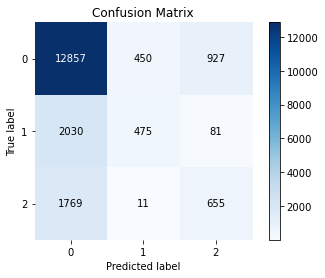

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将预测结果转换为类别标签
y_pred = np.argmax(test_x, axis=1)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy:.4f}")

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(cm)

# 计算F1分数
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {f1:.4f}")

# 绘制混淆矩阵
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()
